<a href="https://colab.research.google.com/github/1kaiser/Media-Segment-Depth-MLP/blob/main/MLP_Image_Train_Inference_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Downloading the dataset**

download [flower dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download) from kaggle.

In [ ]:
from google.colab import output
!wget https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.1/archive.zip -O archive.zip
!unzip /content/archive.zip #unzipping the flower images from archive..
output.clear()
##########################<< copying all varities into a single folder block >>################
!mkdir -p /content/flowers/all
!cp /content/flowers/daisy/* /content/flowers/all
!cp /content/flowers/dandelion/* /content/flowers/all
!cp /content/flowers/rose/* /content/flowers/all
!cp /content/flowers/sunflower/* /content/flowers/all
!cp /content/flowers/tulip/* /content/flowers/all
##########################<< end of block >>################
print("creating single image folder complete >>>")


creating single image folder complete >>>


## **RUN** 

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

**POSITIONAL ENCODING BLOCK** 

In [ ]:
#✅
import jax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [ ]:
#✅
!python -m pip install -q -U flax

import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(ndl):
            x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        return x
##########################################<< MLP MODEL >>#########################################

**initialize the module**

In [ ]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(model, r_key, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
batch_size_no = 64

model = MLPModel() # Instantiate the Model

**defining loss function**

In [ ]:
#serial
def image_difference_loss(logits, labels):
    loss = .5 * jnp.mean((logits - labels) ** 2) 
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [ ]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**image conversion fiunctions**

In [ ]:
from PIL import Image
import jax.numpy as jnp
def imageGRAY(argv):
    im = Image.open(argv).convert('L')
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,1)
    return tvt, tvu
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu

**image dataset, image size and batch size Setup**

In [ ]:
########################################## to load the data in batches as mentioned single batch of images with already provided sizes 
import jax
from jax import random

newsize = (140,140) #(260, 260) # /.... 233 * 454
batch_size = 1

import os
image_dir = r'/content/flowers/tulip/'
#############################################################################
bandend = ["c",".jpg", "b02"]
expression_b2 = bandend[1]
total_images =  [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)]
total_images.sort()
total_images_path = [os.path.join(image_dir, i) for i in total_images if i != 'outputs']
no_of_batches = int(len(total_images_path)/batch_size)

######################################## making 8 array of input for each device >>>
def batchedimages(image_locations):
  RGB8 = jnp.asarray((imageRGB(total_images_path[image_locations[0]])[1]))
  GRAY8 = jnp.asarray((imageGRAY(total_images_path[image_locations[0]])[1]))
  batch_ccc = RGB8, GRAY8 
  return batch_ccc

def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(total_images_path))
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    yield batchedimages(batch_idx)

batches = data_stream()  

In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (140,140) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

from flax.training import checkpoints
if checkpoint_available:
  restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
  #state = flax.jax_utils.replicate(restored_state)
  print("true <<< File loaded for and replicated to all devices")
##########################################
######################<<<< initiating train state
count = 0
if count == 0 :
  HxW, Channels = next(batches)[0].shape
  state = Create_train_state( model, rng, (HxW, Channels), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

######################

total_epochs = 50
for epochs in tqdm(range(total_epochs)):  
  batches = data_stream() 

  if checkpoint_available:
    restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    state = restored_state
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r /content/ckpts

  for bbb in tqdm(range(no_of_batches-5)):
    state, metrics = train_step(state, next(batches), rng)
    output.clear()
    print("loss: ",metrics['loss']," <<< ")
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step= epochs)     # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
  restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################




  0%|          | 0/50 [00:11<?, ?it/s]

loss:  4881.515  <<< 


KeyboardInterrupt: ignored

**inference engine**

--2022-12-28 19:42:23--  https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 13.249.95.215, 2600:9000:21b8:1800:0:5a51:64c9:c681, 2600:9000:21b8:c600:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|13.249.95.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘a.jpg’

a.jpg                   [ <=>                ] 230.86K  --.-KB/s    in 0.03s   

2022-12-28 19:42:24 (6.67 MB/s) - ‘a.jpg’ saved [236398]



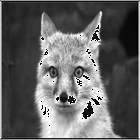

In [ ]:

# newsize = (140,140) #(260, 260) # /.... 233 * 454
from google.colab.patches import cv2_imshow
import numpy as np 
from google.colab import output

!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
image_in = '/content/a.jpg'

from PIL import Image
import jax.numpy as jnp
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu
image = jnp.asarray((imageRGB(image_in)[1]))
#restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
#state = restored_state
prediction = eval_step(state, image)
prediction['loss']


predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize) 
cv2_imshow(predicted_image)


In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
# import numpy as np 
# def show_image(argu):
#   L1 = argu[0]
#   predicted_image = np.array(argu[0],  dtype=np.uint8).reshape(newsize) # This would be your image array
#   a = predicted_image
#   for i in range(0,argu.shape[0]):
#     predicted_image = np.array(argu[i],  dtype=np.uint8).reshape(newsize) 
#     a = cv2.hconcat([a, predicted_image])
#   cv2_imshow(a)

# show_image(metrics['logits'])

In [ ]:
# from jax.tree_util import tree_structure
# print(tree_structure(state))

##**test dataset segmentation Creation download section**

In [2]:

!python -m pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.7 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [4]:
video_location = '/content/drive/MyDrive/OUT/data/machine_learning_test_dataset/test.mp4'
import os

 
# Read images with OpenCV.
#images= None
image_dir = '/content/MEDIAPIPEinput/'
os.makedirs(image_dir, exist_ok=True)
image_dir_out = '/content/annotated_images'
os.makedirs(image_dir_out, exist_ok=True)
frame_rate = 25
!ffmpeg -y -hwaccel cuvid \
  -i {video_location} \
  -r {frame_rate} {image_dir}out_%09d.png

imgs_list = os.listdir(image_dir)
imgs_list.sort()
imgs_path = [os.path.join(image_dir, i) for i in imgs_list if i != 'outputs']

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [5]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import mediapipe as mp
# mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
!rm -r {image_dir}.ipynb_checkpoints

# Run MediaPipe Pose with `enable_segmentation=True` to get pose segmentation.
with mp_pose.Pose(static_image_mode=True, 
                          min_detection_confidence=0.2,
                          model_complexity=2, 
                          enable_segmentation=True,) as pose:
  temp_segmentation_mask =[]                        
  for name, image in enumerate(imgs_path):
    !rm -r {image_dir}.ipynb_checkpoints
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    image = cv2.imread(image)
    results = pose.process(image)

    # Draw pose segmentation.
    print(f'Pose segmentation of {name}:')
    annotated_image_pose = image.copy()
    red_img = np.zeros_like(annotated_image_pose, dtype=np.uint8)
    red_img[:, :] = (255,255,255)
    ###check if segmentation_mask exists or not ## if exists then ok Else use previous mask temporarily
    if results.segmentation_mask is None:
      print("true")
      results.segmentation_mask = temp_segmentation_mask[-1]
      temp_segmentation_mask.append(results.segmentation_mask)
    else:
      temp_segmentation_mask.append(results.segmentation_mask)
    ###End check if segmentation_mask exists or not ## if exists then ok Else use previous mask temporarily
    segm_2class = 0.0 + 1.0 * results.segmentation_mask
    segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
    annotated_image_pose = annotated_image_pose * segm_2class + red_img * (1 - segm_2class)
    #resize_and_show(annotated_image)
    cv2.imwrite('%s/%s' %(image_dir_out, imgs_list[name]), annotated_image_pose)
    !rm -r {image_dir_out}.ipynb_checkpoints


rm: cannot remove '/content/MEDIAPIPEinput/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/MEDIAPIPEinput/.ipynb_checkpoints': No such file or directory
Pose segmentation of 0:
rm: cannot remove '/content/annotated_images.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/MEDIAPIPEinput/.ipynb_checkpoints': No such file or directory
Pose segmentation of 1:
rm: cannot remove '/content/annotated_images.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/MEDIAPIPEinput/.ipynb_checkpoints': No such file or directory
Pose segmentation of 2:
rm: cannot remove '/content/annotated_images.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/MEDIAPIPEinput/.ipynb_checkpoints': No such file or directory
Pose segmentation of 3:
rm: cannot remove '/content/annotated_images.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/MEDIAPIPEinput/.ipynb_checkpoints': No such file or directory


## **RUN 2** 

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

**POSITIONAL ENCODING BLOCK** 

In [6]:
#✅
import jax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [7]:
#✅
!python -m pip install -q -U flax

import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(ndl):
            x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        return x
##########################################<< MLP MODEL >>#########################################

     |████████████████████████████████| 197 kB 5.0 MB/s 
     |████████████████████████████████| 66 kB 5.0 MB/s 
     |████████████████████████████████| 8.3 MB 74.6 MB/s 
     |████████████████████████████████| 154 kB 50.6 MB/s 
     |████████████████████████████████| 237 kB 64.3 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
     |████████████████████████████████| 85 kB 4.2 MB/s 


**initialize the module**

In [8]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(model, r_key, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
batch_size_no = 64

model = MLPModel() # Instantiate the Model

**defining loss function**

In [9]:
#serial
def image_difference_loss(logits, labels):
    loss = .5 * jnp.mean((logits - labels) ** 2) 
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [10]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**image conversion fiunctions**

In [11]:
from PIL import Image
import jax.numpy as jnp
def imageGRAY(argv):
    im = Image.open(argv).convert('L')
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,1)
    return tvt, tvu
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu

**image dataset, image size and batch size Setup**

In [15]:
########################################## to load the data in batches as mentioned single batch of images with already provided sizes 
import jax
from jax import random

newsize = (140,140) #(260, 260) # /.... 233 * 454
batch_size = 1

import os
image_dir = r'/content/MEDIAPIPEinput'
annotated_image_dir = r'/content/annotated_images'

#############################################################################
bandend = ["c",".png", "b02"]
expression_b2 = bandend[1]
total_images =  [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)]
total_images.sort()
total_images_path = [os.path.join(image_dir, i) for i in total_images if i != 'outputs']

annotated_total_images =  [f for f in os.listdir(annotated_image_dir) if f.__contains__(expression_b2)]
annotated_total_images.sort()
annotated_total_images_path = [os.path.join(annotated_image_dir, i) for i in annotated_total_images if i != 'outputs']

no_of_batches = int(len(total_images_path)/batch_size)

######################################## making 8 array of input for each device >>>
def batchedimages(image_locations):
  RGB8 = jnp.asarray((imageRGB(total_images_path[image_locations[0]])[1]))
  ANNOTATED8 = jnp.asarray((imageRGB(annotated_total_images_path[image_locations[0]])[1]))
  batch_ccc = RGB8, ANNOTATED8 
  return batch_ccc

def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(total_images_path))
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    yield batchedimages(batch_idx)

batches = data_stream()  

In [16]:
next(batches)[0].shape

(19600, 3)

In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (140,140) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

from flax.training import checkpoints
if checkpoint_available:
  restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
  #state = flax.jax_utils.replicate(restored_state)
  print("true <<< File loaded for and replicated to all devices")
##########################################
######################<<<< initiating train state
count = 0
if count == 0 :
  HxW, Channels = next(batches)[0].shape
  state = Create_train_state( model, rng, (HxW, Channels), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

######################

total_epochs = 50
for epochs in tqdm(range(total_epochs)):  
  batches = data_stream() 

  if checkpoint_available:
    restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    state = restored_state
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r /content/ckpts

  for bbb in tqdm(range(no_of_batches-5)):
    state, metrics = train_step(state, next(batches), rng)
    output.clear()
    print("loss: ",metrics['loss']," <<< ")
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step= epochs)     # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
  restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################




  4%|▍         | 41/1009 [01:12<26:52,  1.67s/it]

loss:  8939.706  <<< 


**inference engine**

In [ ]:

# newsize = (140,140) #(260, 260) # /.... 233 * 454
from google.colab.patches import cv2_imshow
import numpy as np 
from google.colab import output

!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
image_in = '/content/a.jpg'

from PIL import Image
import jax.numpy as jnp
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu
image = jnp.asarray((imageRGB(image_in)[1]))
#restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
#state = restored_state
prediction = eval_step(state, image)
prediction['loss']


predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize) 
cv2_imshow(predicted_image)


In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow
# import numpy as np 
# def show_image(argu):
#   L1 = argu[0]
#   predicted_image = np.array(argu[0],  dtype=np.uint8).reshape(newsize) # This would be your image array
#   a = predicted_image
#   for i in range(0,argu.shape[0]):
#     predicted_image = np.array(argu[i],  dtype=np.uint8).reshape(newsize) 
#     a = cv2.hconcat([a, predicted_image])
#   cv2_imshow(a)

# show_image(metrics['logits'])

In [ ]:
# from jax.tree_util import tree_structure
# print(tree_structure(state))